In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from langchain_teddynote import logging
logging.langsmith("CH21-AGENT")

LangSmith 추적을 시작합니다.
[프로젝트명]
CH21-AGENT


# MCP 

LangGraph 기반으로 MCP 개념을 반영

In [ ]:
from pydantic import BaseModel
from typing import Dict, Any
from langgraph.graph import StateGraph, END
from langchain_openai import ChatOpenAI
from langchain.schema import SystemMessage

## 1. 모델 정의

In [4]:
llm = ChatOpenAI(model='gpt-3.5-turbo', temperature=0)

## 2. Agent 정의

In [5]:
research_prompt = SystemMessage(content="당신은 리서치 전문가입니다. 주어진 주제에 대해 핵심 정보를 수집하세요.")
summary_prompt = SystemMessage(content="당신은 요약 전문가입니다. 주어진 정보를 명확하고 간결하게 요약하세요.")

In [6]:
# MCP 사상 반영: context에 agent/task/result를 구조화하여 명시
class AgentState(BaseModel):
    topic: str
    context: Dict[str, Any]

In [7]:
def research_agent(state: AgentState) -> AgentState:
    topic = state.topic  

    messages = [
        research_prompt,
        {"role": "user", "content": f"{topic}에 대해 조사해 주세요."}
    ]

    research_result = llm.invoke(messages)

    # MCP 사상 반영: context에 agent/task/result를 구조화하여 명시
    return AgentState(
        topic=state.topic,
        context={
            "agent": "ResearchAgent",
            "task": "research",
            "result": research_result.content
        }
    )

In [8]:
def summary_agent(state: AgentState) -> AgentState:
    research_text = state.context["result"]

    messages = [
        summary_prompt,
        {"role": "user", "content": f"다음 정보를 요약해 주세요:\n{research_text}"}
    ]

    summary_result = llm.invoke(messages)

    # MCP 사상 반영: 에이전트별 task와 결과를 context로 저장
    return AgentState(
        topic=state.topic,
        context={
            "agent": "SummaryAgent",
            "task": "summarize",
            "result": summary_result.content
        }
    )

## 3. Workflow 설계

In [9]:
workflow = StateGraph(AgentState)

workflow.add_node("research", research_agent)
workflow.add_node("summary", summary_agent)

workflow.set_entry_point("research")
workflow.add_edge("research", "summary")
workflow.add_edge("summary", END)

graph = workflow.compile()

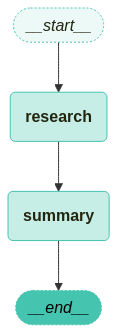

In [10]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(graph)

## 4. 실행

In [13]:
# 실행 예시
initial_state = {
    "topic": "전기차 시장의 최근 이슈",
    "context": {}
}

In [14]:
result = graph.invoke(initial_state)
print("🔍 조사 내용:\n", result["context"]["result"])

🔍 조사 내용:
 전기차 시장에서 주요 이슈는 다음과 같습니다: 1. 전기차의 인기 상승으로 많은 자동차 제조사가 시장에 진출하고 있음. 2. 충전 인프라가 확대되어 전기차 보급이 촉진되고 있음. 3. 전기차 기술과 자율 주행 기술이 융합되어 EVAV의 개발이 진행 중임. 4. 배터리 기술의 발전으로 주행 거리와 성능이 향상되고 있음. 5. 정부 정책이 전기차 보급을 촉진하고 있음. 이러한 이슈들이 전기차 시장의 성장을 촉진하고 있으며, 앞으로 더욱 빠르게 성장할 것으로 예상됨.


----
# NO-MCP

MCP 구조를 따르지 않을 경우의 코드

In [ ]:
# 1. 상태(state) 정의 

# 2. LLM 설정
llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)

# 3. 에이전트 역할별 system prompt 정의
research_prompt = SystemMessage(content="당신은 리서치 전문가입니다. 주어진 주제에 대해 핵심 정보를 수집하세요.")
summary_prompt = SystemMessage(content="당신은 요약 전문가입니다. 주어진 정보를 명확하고 간결하게 요약하세요.")

# 4. Research Agent - 단순 result 필드만 반환
def research_agent(state: dict) -> dict:
    topic = state["topic"]

    messages = [
        research_prompt,
        {"role": "user", "content": f"{topic}에 대해 조사해 주세요."}
    ]

    research_result = llm.invoke(messages)

    # result 필드를 추가해서 상태 확장
    return {
        "topic": state["topic"],
        "result": research_result.content
    }

# 5. Summary Agent - 앞선 결과를 요약하고 다시 result에 덮어씀
def summary_agent(state: dict) -> dict:
    research_text = state["result"]

    messages = [
        summary_prompt,
        {"role": "user", "content": f"다음 정보를 요약해 주세요:\n{research_text}"}
    ]

    summary_result = llm.invoke(messages)

    return {
        "topic": state["topic"],
        "result": summary_result.content
    }

# 6. LangGraph 워크플로우 구성
workflow = StateGraph(dict)
workflow.add_node("research", research_agent)
workflow.add_node("summary", summary_agent)
workflow.set_entry_point("research")
workflow.add_edge("research", "summary")
workflow.add_edge("summary", END)

graph = workflow.compile()


In [21]:
def run_workflow():
    initial_state = {"topic": "전기차 시장의 최근 이슈"}
    result = graph.invoke(initial_state)

    print("\n🔍 최종 결과 (요약된 리서치 내용):\n")
    print(result["result"])

In [22]:
if __name__ == "__main__":
    run_workflow()


🔍 최종 결과 (요약된 리서치 내용):

전기차 시장의 주요 이슈:
1. 전기차의 인기 상승으로 많은 자동차 제조사가 투자하고 있음.
2. 배터리 기술이 발전하며 성능 향상이 이루어지고 있음.
3. 정부 정책이 전기차 보급을 촉진하고 있음.
4. 자율 주행 기술과의 융합이 미래 자동차 산업의 주요 트렌드로 부상.
5. 전기차 시장에서의 치열한 경쟁이 심화되고 있음.


--------
** End of Documents **